## Preprocessing
This file is an example about how to preprocess and generate the input data of the network model.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from clean import DATA

Here, I train the network by six type of star spectra and label them by 0~5. All spectra will be interpolated into a new wavelength, from 3900 Å to 9000 Å.

In [2]:
name_type = {'wdsb2': 0, 'wd': 1, 'yso': 2, 'hotstars': 3, 'fgkm': 4, 'cv': 5}
frac = np.array([0.8, 0.9, 1.0])
w_start = 3900.
w_end = 9000. 
w_len = 3000
wavenew = np.linspace(w_start, w_end, w_len / 1)
dt = np.dtype([('index', 'i4'), ('label', 'i4'),
               ('flux_norm', np.float32, w_len)])

In [3]:
da = DATA()

### Reading data
I use the spectra of hotstars and wd as examples.

In [4]:
Dir = "/nfs/P100/SDSSV_Classifiers/data/optical"

In [5]:
keys = ["hotstars","wd"]
fps = []
labelarr = []
for i in keys:
    with open("/nfs/P100/SDSSV_Classifiers/processed_dataset/filename/%s_test.txt"%i, 'r') as f:
        fnames = f.readlines()
    for j in range(len(fnames)):
        fnames[j] = "{}/{}".format(i,fnames[j][:-1])
        labelarr.append(name_type[i])
    fps+=fnames
labelarr = np.array(labelarr)
print len(fps)

870


### load spectrum
The `read` function in `DATA` class is used to read fits file, which is copied from https://dr15.sdss.org/sas/sdss5/mwm/sandbox/classifier/training/loadspec.py. But take it easy, you can use any data format only if it has wavelength and flux information.

In [6]:
spec = []
for fp in fps[:10]:
    spec.append(da.read(os.path.join(Dir,fp)))
print spec[0]

<class loadspec.Spec1D at 0x7f8b8de8ce88>
BOSS spec Optical spectrum
File = /nfs/P100/SDSSV_Classifiers/data/optical/hotstars/spec-8175-57039-0798.fits
S/N =   21.54
Flux = [ 26.581879  18.972857  11.239796 ... -26.327734  25.048307  18.847332]
Err = [ 6.722233  6.666507  6.111193 ... 17.39934  21.821981 28.822857]
Wave = [ 3614.0994  3614.9307  3615.7625 ... 10394.412  10396.809  10401.593 ]


The function `smooth4test` in `DATA` class contains the Gaussian smoothing and interpolation, which are the main preprocessing before run the network. You can find more details by reading code. The input of the `smooth4test` function `data` is a python dictionary, whose key is the index of spectrum. Each value in `data` dictionary must be a dictionary with 4 keys: "index", "label", "wave", "flux". The "index" and "label" are not important and can be assigned anything. For the "wave" and "flux", you should assign the wavelength array and flux array into them.

In [7]:
data = {}
for i in range(len(spec)):
    index = i 
    label = -1
    wave = spec[i].wave
    flux = spec[i].flux
    data[i] = {
        "index": index,
        "label": label,
        "wave": wave,
        "flux": flux}

In [8]:
dataset = da.smooth4test(wavenew, data, sigma=200)

mask 0 elements from 10 spectra...


This figure shows the spectrum without and with preprocessing.

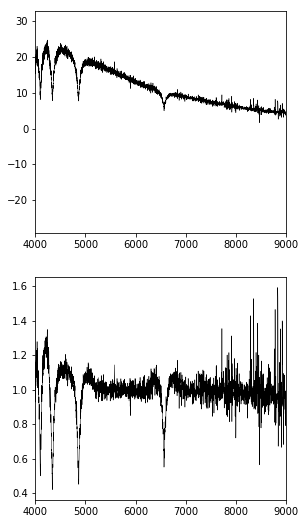

In [9]:
fig, axes = plt.subplots(2,1,figsize=(4.5,9))
ax = axes[0]
ax.plot(spec[0].wave, spec[0].flux, 'k-', lw=0.5)
ax.set_xlim([4000,9000])
ax = axes[1]
ax.plot(wavenew, dataset[0]["flux_norm"], 'k-', lw=0.5)
ax.set_xlim([4000,9000])
fig.savefig('./result/preprocessing.png')